In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as rick
%matplotlib widget
from ipywidgets import *
from matplotlib.widgets import Slider, Button
from matplotlib.animation import FuncAnimation

def t_max(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 + (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def t_min(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 - (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

alpha = 1 / 132.184
m_W = 80.379
m_Z = 91.1876
m_e = 0.511E-3
m_m = 105.66E-3
m_tau = 1776.86E-3
m_h = 125.1
e = (4 * np.pi * alpha) ** 0.5
cos = m_W / m_Z
sin = np.sqrt(1 - cos ** 2)
v = 2 * m_W * sin / e
Gam_Z = 2.4952
pi = np.pi
SW = sin
CW = cos
MZ2 = m_Z ** 2

m = m_m
E_phot_min = 5
t_min_fix = 4 * m ** 2
t_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2

CeB = 10 ** -10
CeW = CeB
CeH = 10 ** -10
CHB = 2 * 10 ** -10
CHW = 10 ** -10
CHD = 10 ** -10
CHWB = CHD
CHbox = 10 ** -10
CHAA = cos ** 2 * CHB + sin ** 2 * CHW - sin * cos * CHWB
CHAZ = 2 * sin * cos * (CHW - CHB) - (cos ** 2 - sin ** 2) * CHWB
bins = 200

def diff_decay2(s, t, m, CeB, CeW, CeH, CHD, CHbox, CHB, CHW, CHWB):
    CHAA = sin ** 2 * CHB + sin ** 2 * CHW - sin * cos * CHWB
    CHAZ = 2 * sin * cos * (CHW - CHB) - (cos ** 2 - sin ** 2) * CHWB
    SW = sin
    CW = cos
    pi = np.pi
    N = 1 / (32 * (2 * pi) ** 3  * m_h ** 3)
    
    struc_4 = -16*pi**2*alpha**2*m**2*(m_h**4 + s**2)/(SW**2*m_W**2*t*(-m_h**2 + s + t)) #selfTree_py
    
    struc_6_AA = 64*pi*CHAA*alpha*m**2*(-m_h**6 + 3*m_h**4*s - m_h**2*s*(3*s + 4*t) + s*(s + 2*t)**2)/(s*t*(-m_h**2 + s + t)) #TreeHAA_py
    struc_6_AZ = 8*pi*CHAZ*alpha*m**2*(CW**2 - 3*SW**2)*(-Gam_Z**2 + MZ2 - s)*(-m_h**6 + 3*m_h**4*s - m_h**2*s*(3*s + 4*t) + s*(s + 2*t)**2)/(CW*SW*t*(4*Gam_Z**2*MZ2 + (-Gam_Z**2 + MZ2 - s)**2)*(-m_h**2 + s + t)) #TreeHAZ_py
    struc_6_eBeW = 16*np.sqrt(2)*pi*alpha*m*m_h**2*(-CW*CeB + CeW*SW)/(SW*m_W) #TreeDip_py
    struc_61_rem = 16*np.sqrt(2)*pi*CeH*alpha*m*v*(m_h**4 + s**2)/(t*(-m_h**2 + s + t)) #TreeRem_py
    struc_62_rem = - 8*pi*alpha*m**2*(m_h**4 + s**2)*(CHD*(2*CW**2 - 1) + 4*SW*(CHWB*CW + CHbox*SW))/(SW**2*t*(-m_h**2 + s + t))
    
    struc_8_AA = 64*CHAA**2*SW**2*m_W**2*(m_h**4 - m_h**2*(2*s + 2*t) + s**2 + 2*s*t + 2*t**2)/s #selfHAA_py
    struc_8_AZ = 2*CHAZ**2*m_W**2*s*(t**2 + (-m_h**2 + s + t)**2)*(CW**4 - 2*CW**2*SW**2 + 5*SW**4)/(CW**2*(Gam_Z**2*MZ2 + (MZ2 - s)**2)) #selfHAZ_py
    struc_8_AAAZ = 16*CHAA*CHAZ*SW*m_W**2*(CW**2 - 3*SW**2)*(-Gam_Z**2 + MZ2 - s)*(m_h**4 - m_h**2*(2*s + 2*t) + s**2 + 2*s*t + 2*t**2)/(CW*(4*Gam_Z**2*MZ2 + (-Gam_Z**2 + MZ2 - s)**2)) #HAAHAZ_py
    struc_8_eBeW = -8*t*(CW*CeB - CeW*SW)**2*(-m_h**2 + s + t) #selfDip_py
    struc_8_rem = -8*CeH**2*SW**2*m_W**2*v**2*(m_h**4 + s**2)/(t*(-m_h**2 + s + t)) #selfRem_py
    
    return N * np.concatenate((np.array([struc_4]), np.array([struc_6_AA, struc_6_AZ, struc_6_eBeW, struc_61_rem, struc_62_rem]), np.array([struc_8_AA, struc_8_AZ, struc_8_AAAZ, struc_8_eBeW, struc_8_rem])), axis=0)

def scale(l, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    
    HAA = cos ** 2 * iHB + sin ** 2 * iHW - sin * cos * iHWB
    HAZ = 2 * sin * cos * (iHW - iHB) - (cos ** 2 - sin ** 2) * iHWB
    init = (m / (v * 10 ** 6)) * np.array([HAA, HAZ, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB])
    I = []
    
    SM4 = l[0]
    
    AA6 = (init[0] / CHAA) * l[1]
    AZ6 = (init[1] / CHAZ) * l[2]
    eBeW6 = ((sin * init[3] - cos * init[2]) / (sin * CeW - cos * CeB)) * l[3]
    rem1 = (init[4] / CeH) * l[4]
    rem2 = ((init[5]*(2*cos**2 - 1)+ 4*sin*(init[9]*cos + init[6]*sin)) / (CHD*(2*cos**2 - 1)+ 4*sin*(CHWB*cos + CHbox*sin))) * l[5]
    
    AA8 = (init[0] ** 2 / CHAA ** 2) * l[6]
    AZ8 = (init[1] ** 2 / CHAZ ** 2) * l[7]
    AAAZ8 = ((init[0] * init[1]) / (CHAA * CHAZ)) * l[8]
    eBeW8 = ((cos * init[2] - sin * init[3]) ** 2 / (cos * CeB - sin * CeW) ** 2) * l[9]
    rem8 = (init[4] ** 2 / CeH ** 2) * l[10]
    
    I.append(SM4)
    I.append(AA6)
    I.append(AZ6)
    I.append(eBeW6)
    I.append(rem1)
    I.append(rem2)
    I.append(AA8)
    I.append(AZ8)
    I.append(AAAZ8)
    I.append(eBeW8)
    I.append(rem8)
    
    return I

def scale_anim(l, CHBs, CHWs, CHWBs, CeHs, CeBs, CeWs, CHboxs, CHDs):
    I = []
    for i in range(0, len(C_HBs)):
        
        CHAAi = cos ** 2 * CHBs[i] + sin ** 2 * CHWs[i] - sin * cos * CHWBs[i]
        CHAZi = 2 * sin * cos * (CHWs[i] - CHBs[i]) - (cos ** 2 - sin ** 2) * CHWBs[i]
        
        SM4 = l[0]
    
        AA6 = (CHAAi / CHAA) * l[1]
        AZ6 = (CHAZi / CHAZ) * l[2]
        eBeW6 = ((sin * CeWs[i] - cos * CeBs[i]) / (sin * CeW - cos * CeB)) * l[3]
        rem1 = (CeHs[i] / CeH) * l[4]
        rem2 = ((CHDs[i]*(2*cos**2 - 1)+ 4*sin*(CHWBs[i]*cos + CHboxs[i]*sin)) / (CHD*(2*cos**2 - 1)+ 4*sin*(CHWB*cos + CHbox*sin))) * l[5]
    
        AA8 = (CHAAi ** 2 / CHAA ** 2) * l[6]
        AZ8 = (CHAZi ** 2 / CHAZ ** 2) * l[7]
        AAAZ8 = ((CHAAi * CHAZi) / (CHAA * CHAZ)) * l[8]
        eBeW8 = ((cos * CeBs[i] - sin * CeWs[i]) ** 2 / (cos * CeB - sin * CeW) ** 2) * l[9]
        rem8 = (CeHs[i] ** 2 / CeH ** 2) * l[10]
        
        I.append(np.concatenate((SM4, AA6, AZ6, eBeW6, rem1, rem2, AA8, AZ8, AAAZ8, eBeW8, rem8), axis = 0))
    return np.array(I)

In [67]:
rick.load(open('I_LoopSM_muon_result_new', 'rb'))

[2.7315620575022925e-07, 2.7824395355485645e-09]

In [68]:
print((m_h ** 2 - 2 * m_h * E_phot_min)**0.5)

119.99587492909912


In [15]:
I_cos4_1 = np.array(rick.load(open('I_cos41_Tree', 'rb')))
I_cos6_1 = np.array(rick.load(open('I_cos61_Tree', 'rb')))
I_cos6_2 = np.array(rick.load(open('I_cos62_Tree', 'rb')))
I_cos6_3 = np.array(rick.load(open('I_cos63_Tree', 'rb')))
I_cos6_4 = np.array(rick.load(open('I_cos64_Tree', 'rb')))
I_cos6_5 = np.array(rick.load(open('I_cos65_Tree', 'rb')))
I_cos8_6 = np.array(rick.load(open('I_cos86_Tree', 'rb')))
I_cos8_7 = np.array(rick.load(open('I_cos87_Tree', 'rb')))
I_cos8_8 = np.array(rick.load(open('I_cos88_Tree', 'rb')))
I_cos8_9 = np.array(rick.load(open('I_cos89_Tree', 'rb')))
I_cos8_10 = np.array(rick.load(open('I_cos810_Tree', 'rb')))
mas_ls = [I_cos4_1, I_cos6_1, I_cos6_2, I_cos6_3, I_cos6_4, I_cos6_5, I_cos8_6, I_cos8_7, I_cos8_8, I_cos8_9, I_cos8_10]
num = 2
C_HBs = np.linspace(0, 100, num) * (m_m / (v * 10 ** 6))
C_HWs = np.linspace(0, 10, num) * (m_m / (v * 10 ** 6))
C_HWBs = C_HWs
C_eHs = C_HWs
C_eBs = np.ones(num) * 0.1 * (m_m / (v * 10 ** 6))
C_eWs = C_eBs
C_Hboxs = C_eBs
C_HDs = C_eBs

# CHBs, CHWs, CHWBs, CeHs, CeBs, CeWs, CHboxs, CHDs
print(scale_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs))

[[[ 2.68215151e-10  4.21115855e-10  4.04440660e-10 ...  4.82924718e-25
    3.28794884e-24 -1.55390970e-25]
  [ 2.04850012e-12  2.72521530e-12  2.92194922e-12 ...  7.97440553e-27
    7.25668923e-27  6.99789769e-27]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   -0.00000000e+00 -0.00000000e+00]
  ...
  [ 2.46496408e-20  4.22819367e-20  5.47190587e-20 ...  5.57828958e-32
    4.79589581e-32  4.51741400e-32]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   -0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 2.68215151e-10  4.21115855e-10  4.04440660e-10 ...  4.82924718e-25
    3.28794884e-24 -1.55390970e-25]
  [ 2.04850012e-12  2.72521530e-12  2.92194922e-12 ...  7.97440553e-27
    7.25668923e-27  6.99789769e-27]
  [ 3.73106940e-12  3.46378283e-12  2.11169668e-12 ...  1.06912466e-25
   -6.55196810e-26 -2.61702987e-25]
  ...
  [ 2.46496408e-20  4.2

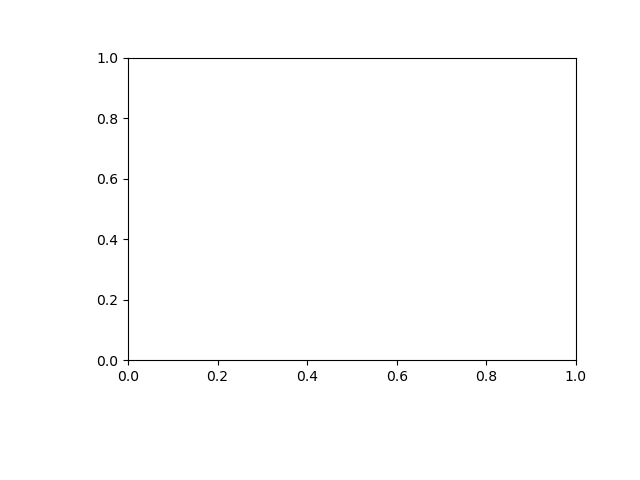

In [51]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.2, bottom=0.25)

num = 10

C_HBs = np.linspace(0, 100, num) * (m_m / (v * 10 ** 6))
C_HWs = np.linspace(0, 10, num) * (m_m / (v * 10 ** 6))
C_HWBs = C_HWs
C_eHs = C_HWs
C_eBs = np.ones(num) * 0.1 * (m_m / (v * 10 ** 6))
C_eWs = C_eBs
C_Hboxs = C_eBs
C_HDs = C_eBs

norm = 2 / bins
keV = 1
cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
I_cos4_1 = np.array(rick.load(open('I_cos41_Tree', 'rb')))
I_cos6_1 = np.array(rick.load(open('I_cos61_Tree', 'rb')))
I_cos6_2 = np.array(rick.load(open('I_cos62_Tree', 'rb')))
I_cos6_3 = np.array(rick.load(open('I_cos63_Tree', 'rb')))
I_cos6_4 = np.array(rick.load(open('I_cos64_Tree', 'rb')))
I_cos6_5 = np.array(rick.load(open('I_cos65_Tree', 'rb')))
I_cos8_6 = np.array(rick.load(open('I_cos86_Tree', 'rb')))
I_cos8_7 = np.array(rick.load(open('I_cos87_Tree', 'rb')))
I_cos8_8 = np.array(rick.load(open('I_cos88_Tree', 'rb')))
I_cos8_9 = np.array(rick.load(open('I_cos89_Tree', 'rb')))
I_cos8_10 = np.array(rick.load(open('I_cos810_Tree', 'rb')))
mas_ls = [I_cos4_1, I_cos6_1, I_cos6_2, I_cos6_3, I_cos6_4, I_cos6_5, I_cos8_6, I_cos8_7, I_cos8_8, I_cos8_9, I_cos8_10]
integral = 0
for i in mas_ls:
    integral += np.sum(i[0])

def cos_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs):
    k = 1 / norm
    return k * scale_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)

def cos_4sum_init(i):
    cos_4sum = 0
    cos_4errsum = 0
    for j in range(0, 1):
        cos_4sum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_4errsum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_4sum, cos_4errsum])

def cos_6sum_init(i):
    cos_6sum = 0
    cos_6errsum = 0
    for j in range(1, 6):
        cos_6sum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_6errsum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_6sum, cos_6errsum])

def cos_8sum_init(i):
    cos_8sum = 0
    cos_8errsum = 0
    for j in range(6, 11):
        cos_8sum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_8errsum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_8sum, cos_8errsum])

def animate(i):
    ax.clear()
    plt.ylim(-0.5*10**-7, 2*10**-7)
    #plt.yscale('log')
    ax.errorbar(cos_s, cos_4sum_init(i)[0],  color = 'green', label = 'SM', yerr = cos_4sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(cos_s, cos_6sum_init(i)[0],  color = 'orange', label = 'SM-SMEFT', yerr = cos_6sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(cos_s, cos_8sum_init(i)[0],  color = 'red', label = 'SMEFT-SMEFT', yerr = cos_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.tick_params(direction='in', length=4, width=1)
    ax.errorbar(cos_s, cos_4sum_init(i)[0]+cos_6sum_init(i)[0]+cos_8sum_init(i)[0],  color = 'black', label = 'Total', yerr = cos_4sum_init(i)[1]+cos_6sum_init(i)[1]+cos_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.text(-0.8, 2.1*10**-7, r'$x(C_{HWB})=x(C_{HW})=x(C_{eH})=$' +str(round(C_HWBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(-0.8, 2.3*10**-7, r'$x(C_{HB})=$' +str(round(C_HBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(0.4, 2.1*10**-7, r'$x(C_{eB})=x(C_{eW})=$' +str(round(C_eBs[i] * ((v * 10 ** 6) / m_m),2))+'', fontsize = 10)
    plt.ylabel(r'$\frac{d\Gamma}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
    plt.legend(loc='upper center', fontsize = 8)
    
anim = FuncAnimation(fig, animate, interval=200, frames=num, repeat=False)
#anim.save('cos_lk.gif', writer='pillow')
plt.show()

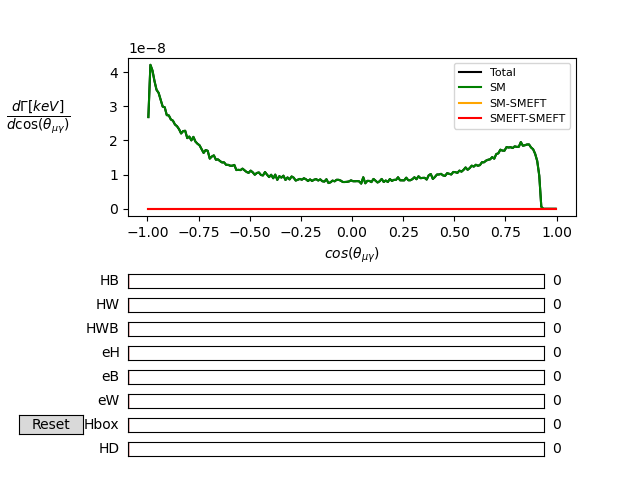

In [26]:
iHB_init = 0 
iHW_init = 0
iHWB_init = 0
ieH_init = 0
ieB_init = 0 
ieW_init = 0
iHD_init = 0
iHbox_init = 0

norm = 2 / bins
k = 1 / norm
cot_s = []
for i in range(0, bins):
    cot_s += [-1 + (i + 0.5) * 2 / bins]
    
I_cos4_1 = np.array(rick.load(open('I_cos41_Tree', 'rb')))
I_cos6_1 = np.array(rick.load(open('I_cos61_Tree', 'rb')))
I_cos6_2 = np.array(rick.load(open('I_cos62_Tree', 'rb')))
I_cos6_3 = np.array(rick.load(open('I_cos63_Tree', 'rb')))
I_cos6_4 = np.array(rick.load(open('I_cos64_Tree', 'rb')))
I_cos6_5 = np.array(rick.load(open('I_cos65_Tree', 'rb')))
I_cos8_6 = np.array(rick.load(open('I_cos86_Tree', 'rb')))
I_cos8_7 = np.array(rick.load(open('I_cos87_Tree', 'rb')))
I_cos8_8 = np.array(rick.load(open('I_cos88_Tree', 'rb')))
I_cos8_9 = np.array(rick.load(open('I_cos89_Tree', 'rb')))
I_cos8_10 = np.array(rick.load(open('I_cos810_Tree', 'rb')))
mas_ls = [I_cos4_1, I_cos6_1, I_cos6_2, I_cos6_3, I_cos6_4, I_cos6_5, I_cos8_6, I_cos8_7, I_cos8_8, I_cos8_9, I_cos8_10]

def cot_4sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    cot_4sum = 0
    cot_4errsum = 0
    for j in range(0, 1):
        cot_4sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        cot_4errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return k * np.array([cot_4sum, cot_4errsum])

def cot_6sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    cot_6sum = 0
    cot_6errsum = 0
    for j in range(1, 6):
        cot_6sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        cot_6errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return k * np.array([cot_6sum, cot_6errsum])

def cot_8sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    cot_8sum = 0
    cot_8errsum = 0
    for j in range(6, 11):
        cot_8sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        cot_8errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return k * np.array([cot_8sum, cot_8errsum])

fig, ax = plt.subplots()
#plt.yscale('log')
#plt.ylim(-0.1, 1)
line_sum, = ax.plot(cot_s, cot_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] + cot_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] + cot_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'black', label = 'Total')
line_4, = ax.plot(cot_s, cot_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'green', label = 'SM')
line_6, = ax.plot(cot_s, cot_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'orange', label = 'SM-SMEFT')
line_8, = ax.plot(cot_s, cot_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'red', label = 'SMEFT-SMEFT')
ax.set_ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.legend(fontsize = 8)

fig.subplott_adjust(left=0.2, bottom=0.55)

axs = fig.add_axes([0.2, 0.4, 0.65, 0.03])
HB_slider = Slider(
    ax=axs,
    label='HB',
    valmin=0,
    valmax=100,
    valinit=iHB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.35, 0.65, 0.03])
HW_slider = Slider(
    ax=axs,
    label='HW',
    valmin=0,
    valmax=100,
    valinit=iHW_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.3, 0.65, 0.03])
HWB_slider = Slider(
    ax=axs,
    label='HWB',
    valmin=0,
    valmax=100,
    valinit=iHWB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.25, 0.65, 0.03])
eH_slider = Slider(
    ax=axs,
    label='eH',
    valmin=0,
    valmax=100,
    valinit=ieH_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.2, 0.65, 0.03])
eB_slider = Slider(
    ax=axs,
    label='eB',
    valmin=0,
    valmax=1000,
    valinit=ieB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.15, 0.65, 0.03])
eW_slider = Slider(
    ax=axs,
    label='eW',
    valmin=0,
    valmax=100,
    valinit=ieW_init,
    color = 'gray')
                          
axs = fig.add_axes([0.2, 0.1, 0.65, 0.03])
Hbox_slider = Slider(
    ax=axs,
    label='Hbox',
    valmin=0,
    valmax=100,
    valinit=iHbox_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.05, 0.65, 0.03])
HD_slider = Slider(
    ax=axs,
    label='HD',
    valmin=0,
    valmax=100,
    valinit=iHD_init,
    color = 'gray')                          
                          
def update(val):
    line_sum.set_ydata(cot_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] + cot_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] + cot_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_4.set_ydata(cot_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_6.set_ydata(cot_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_8.set_ydata(cot_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    fig.canvas.draw_idle()

HB_slider.on_changed(update)
HW_slider.on_changed(update)
HWB_slider.on_changed(update)
eH_slider.on_changed(update)
eB_slider.on_changed(update)
eW_slider.on_changed(update)
Hbox_slider.on_changed(update)
HD_slider.on_changed(update)                          

resetax = fig.add_axes([0.03, 0.095, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    HB_slider.reset()
    HW_slider.reset()
    HWB_slider.reset()
    eH_slider.reset()
    eB_slider.reset()
    eW_slider.reset()
    Hbox_slider.reset()
    HD_slider.reset()                     
button.on_clicked(reset)

plt.show()

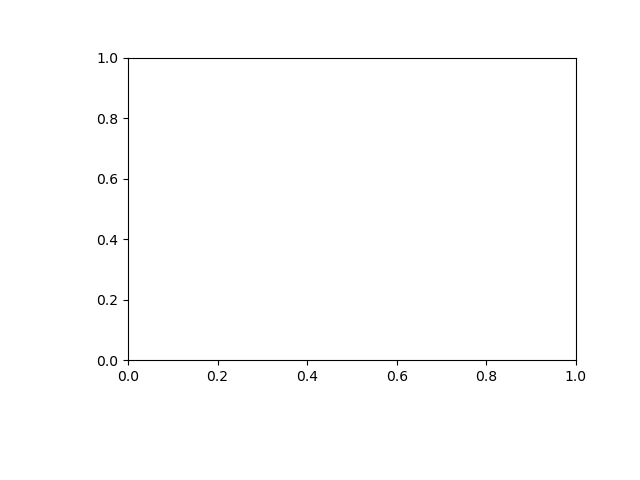

In [61]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.2, bottom=0.25)

num = 10

C_HBs = np.linspace(0, 100, num) * (m_m / (v * 10 ** 6))
C_HWs = np.linspace(0, 10, num) * (m_m / (v * 10 ** 6))
C_HWBs = C_HWs
C_eHs = C_HWs
C_eBs = np.ones(num) * 0.1 * (m_m / (v * 10 ** 6))
C_eWs = C_eBs
C_Hboxs = C_eBs
C_HDs = C_eBs

norm = 2 / bins
keV = 1
cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
I_cos_alt4_1 = np.array(rick.load(open('I_cosalt41_Tree', 'rb')))
I_cos_alt6_1 = np.array(rick.load(open('I_cosalt61_Tree', 'rb')))
I_cos_alt6_2 = np.array(rick.load(open('I_cosalt62_Tree', 'rb')))
I_cos_alt6_3 = np.array(rick.load(open('I_cosalt63_Tree', 'rb')))
I_cos_alt6_4 = np.array(rick.load(open('I_cosalt64_Tree', 'rb')))
I_cos_alt6_5 = np.array(rick.load(open('I_cosalt65_Tree', 'rb')))
I_cos_alt8_6 = np.array(rick.load(open('I_cosalt86_Tree', 'rb')))
I_cos_alt8_7 = np.array(rick.load(open('I_cosalt87_Tree', 'rb')))
I_cos_alt8_8 = np.array(rick.load(open('I_cosalt88_Tree', 'rb')))
I_cos_alt8_9 = np.array(rick.load(open('I_cosalt89_Tree', 'rb')))
I_cos_alt8_10 = np.array(rick.load(open('I_cosalt810_Tree', 'rb')))
mas_ls = [I_cos_alt4_1, I_cos_alt6_1, I_cos_alt6_2, I_cos_alt6_3, I_cos_alt6_4, I_cos_alt6_5, I_cos_alt8_6, I_cos_alt8_7, I_cos_alt8_8, I_cos_alt8_9, I_cos_alt8_10]

def cos_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs):
    k = keV / norm
    return k * scale_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)

def cos_alt_4sum_init(i):
    cos_4sum = 0
    cos_4errsum = 0
    for j in range(0, 1):
        cos_4sum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_4errsum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_4sum, cos_4errsum])

def cos_alt_6sum_init(i):
    cos_6sum = 0
    cos_6errsum = 0
    for j in range(1, 6):
        cos_6sum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_6errsum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_6sum, cos_6errsum])

def cos_alt_8sum_init(i):
    cos_8sum = 0
    cos_8errsum = 0
    for j in range(6, 11):
        cos_8sum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_8errsum += cos_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_8sum, cos_8errsum])
#print(cos_alt_4sum_init(i)[0])
def animate(i):
    ax.clear()
    plt.ylim(-0.5*10**-7, 0.15*10**-6)
    #plt.yscale('log')
    ax.errorbar(cos_s, cos_alt_4sum_init(i)[0],  color = 'green', label = 'SM', yerr = cos_alt_4sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(cos_s, cos_alt_6sum_init(i)[0],  color = 'orange', label = 'SM-SMEFT', yerr = cos_alt_6sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(cos_s, cos_alt_8sum_init(i)[0],  color = 'red', label = 'SMEFT-SMEFT', yerr = cos_alt_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.tick_params(direction='in', length=4, width=1)
    ax.errorbar(cos_s, cos_alt_4sum_init(i)[0]+cos_alt_6sum_init(i)[0]+cos_alt_8sum_init(i)[0],  color = 'black', label = 'Total', yerr = cos_alt_4sum_init(i)[1]+cos_alt_6sum_init(i)[1]+cos_alt_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    plt.ylabel(r'$\frac{d\Gamma}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
    ax.text(-0.8, 0.155*10**-6, r'$x(C_{HWB})=x(C_{HW})=x(C_{eH})=$' +str(round(C_HWBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(-0.8, 0.17*10**-6, r'$x(C_{HB})=$' +str(round(C_HBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(0.4, 0.155*10**-6, r'$x(C_{eB})=x(C_{eW})=$' +str(round(C_eBs[i] * ((v * 10 ** 6) / m_m),2))+'', fontsize = 10)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    plt.xlabel(r'$cos(\theta_{\mu\mu})$')
    plt.legend(loc='upper center', fontsize = 8)
    
anim = FuncAnimation(fig, animate, interval=200, frames=num, repeat=False)
#anim.save('cos_ll.gif', writer='pillow')
plt.show()

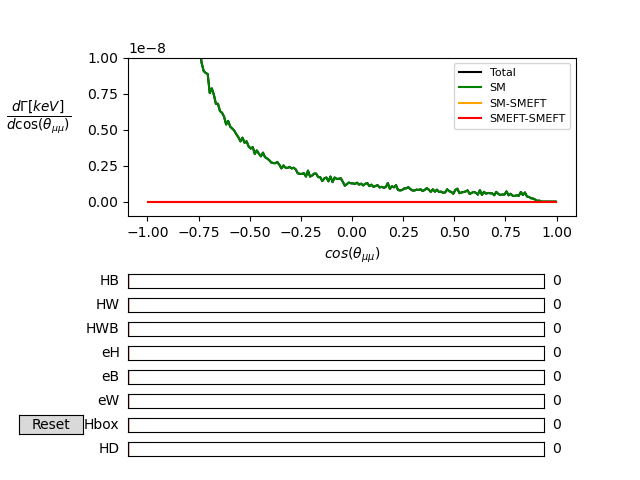

In [29]:
iHB_init = 0 
iHW_init = 0
iHWB_init = 0
ieH_init = 0
ieB_init = 0 
ieW_init = 0
iHD_init = 0
iHbox_init = 0

norm = 2 / bins
k = 1 / norm
cosalt_s = []
for i in range(0, bins):
    cosalt_s += [-1 + (i + 0.5) * 2 / bins]
    
I_cosalt4_1 = np.array(rick.load(open('I_cosalt41_Tree', 'rb')))
I_cosalt6_1 = np.array(rick.load(open('I_cosalt61_Tree', 'rb')))
I_cosalt6_2 = np.array(rick.load(open('I_cosalt62_Tree', 'rb')))
I_cosalt6_3 = np.array(rick.load(open('I_cosalt63_Tree', 'rb')))
I_cosalt6_4 = np.array(rick.load(open('I_cosalt64_Tree', 'rb')))
I_cosalt6_5 = np.array(rick.load(open('I_cosalt65_Tree', 'rb')))
I_cosalt8_6 = np.array(rick.load(open('I_cosalt86_Tree', 'rb')))
I_cosalt8_7 = np.array(rick.load(open('I_cosalt87_Tree', 'rb')))
I_cosalt8_8 = np.array(rick.load(open('I_cosalt88_Tree', 'rb')))
I_cosalt8_9 = np.array(rick.load(open('I_cosalt89_Tree', 'rb')))
I_cosalt8_10 = np.array(rick.load(open('I_cosalt810_Tree', 'rb')))
mas_ls = [I_cosalt4_1, I_cosalt6_1, I_cosalt6_2, I_cosalt6_3, I_cosalt6_4, I_cosalt6_5, I_cosalt8_6, I_cosalt8_7, I_cosalt8_8, I_cosalt8_9, I_cosalt8_10]

def cosalt_4sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    cosalt_4sum = 0
    cosalt_4errsum = 0
    for j in range(0, 1):
        cosalt_4sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        cosalt_4errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return k * np.array([cosalt_4sum, cosalt_4errsum])

def cosalt_6sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    cosalt_6sum = 0
    cosalt_6errsum = 0
    for j in range(1, 6):
        cosalt_6sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        cosalt_6errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return k * np.array([cosalt_6sum, cosalt_6errsum])

def cosalt_8sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    cosalt_8sum = 0
    cosalt_8errsum = 0
    for j in range(6, 11):
        cosalt_8sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        cosalt_8errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return k * np.array([cosalt_8sum, cosalt_8errsum])

fig, ax = plt.subplots()
#plt.yscale('log')
plt.ylim(-10**-9, 10**-8)
line_sum, = ax.plot(cosalt_s, cosalt_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] + cosalt_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] + cosalt_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'black', label = 'Total')
line_4, = ax.plot(cosalt_s, cosalt_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'green', label = 'SM')
line_6, = ax.plot(cosalt_s, cosalt_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'orange', label = 'SM-SMEFT')
line_8, = ax.plot(cosalt_s, cosalt_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'red', label = 'SMEFT-SMEFT')
ax.set_ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel(r'$cos(\theta_{\mu\mu})$')
plt.legend(fontsize = 8)

fig.subplott_adjust(left=0.2, bottom=0.55)

axs = fig.add_axes([0.2, 0.4, 0.65, 0.03])
HB_slider = Slider(
    ax=axs,
    label='HB',
    valmin=0,
    valmax=100,
    valinit=iHB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.35, 0.65, 0.03])
HW_slider = Slider(
    ax=axs,
    label='HW',
    valmin=0,
    valmax=100,
    valinit=iHW_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.3, 0.65, 0.03])
HWB_slider = Slider(
    ax=axs,
    label='HWB',
    valmin=0,
    valmax=100,
    valinit=iHWB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.25, 0.65, 0.03])
eH_slider = Slider(
    ax=axs,
    label='eH',
    valmin=0,
    valmax=100,
    valinit=ieH_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.2, 0.65, 0.03])
eB_slider = Slider(
    ax=axs,
    label='eB',
    valmin=0,
    valmax=1000,
    valinit=ieB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.15, 0.65, 0.03])
eW_slider = Slider(
    ax=axs,
    label='eW',
    valmin=0,
    valmax=100,
    valinit=ieW_init,
    color = 'gray')
                          
axs = fig.add_axes([0.2, 0.1, 0.65, 0.03])
Hbox_slider = Slider(
    ax=axs,
    label='Hbox',
    valmin=0,
    valmax=100,
    valinit=iHbox_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.05, 0.65, 0.03])
HD_slider = Slider(
    ax=axs,
    label='HD',
    valmin=0,
    valmax=100,
    valinit=iHD_init,
    color = 'gray')                          
                          
def update(val):
    line_sum.set_ydata(cosalt_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] + cosalt_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] + cosalt_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_4.set_ydata(cosalt_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_6.set_ydata(cosalt_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_8.set_ydata(cosalt_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    fig.canvas.draw_idle()

HB_slider.on_changed(update)
HW_slider.on_changed(update)
HWB_slider.on_changed(update)
eH_slider.on_changed(update)
eB_slider.on_changed(update)
eW_slider.on_changed(update)
Hbox_slider.on_changed(update)
HD_slider.on_changed(update)                          

resetax = fig.add_axes([0.03, 0.095, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    HB_slider.reset()
    HW_slider.reset()
    HWB_slider.reset()
    eH_slider.reset()
    eB_slider.reset()
    eW_slider.reset()
    Hbox_slider.reset()
    HD_slider.reset()                     
button.on_clicked(reset)

plt.show()

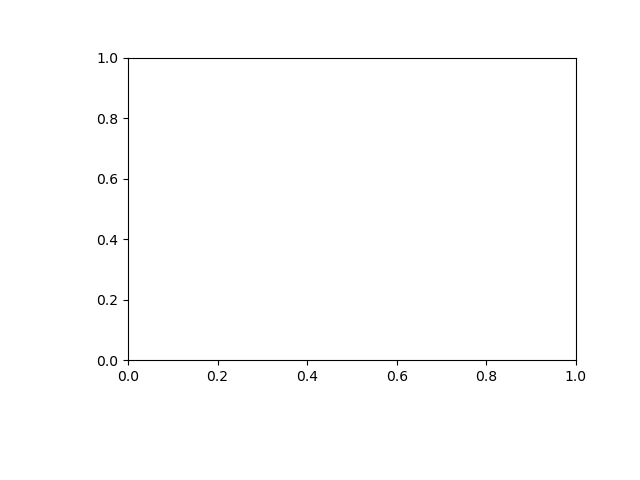

In [65]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.2, bottom=0.25)

num = 10
K = 0.1

C_HBs = np.linspace(0, 100, num) * (m_m / (v * 10 ** 6))
C_HWs = np.linspace(0, 10, num) * (m_m / (v * 10 ** 6))
C_HWBs = C_HWs
C_eHs = C_HWs
C_eBs = np.ones(num) * 0.1 * (m_m / (v * 10 ** 6))
C_eWs = C_eBs
C_Hboxs = C_eBs
C_HDs = C_eBs

sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
sqs = np.array(ss) ** 0.5

I_4_1 = np.array(rick.load(open('I_41_Tree', 'rb')))
I_6_1 = np.array(rick.load(open('I_61_Tree', 'rb')))
I_6_2 = np.array(rick.load(open('I_62_Tree', 'rb')))
I_6_3 = np.array(rick.load(open('I_63_Tree', 'rb')))
I_6_4 = np.array(rick.load(open('I_64_Tree', 'rb')))
I_6_5 = np.array(rick.load(open('I_65_Tree', 'rb')))
I_8_6 = np.array(rick.load(open('I_86_Tree', 'rb')))
I_8_7 = np.array(rick.load(open('I_87_Tree', 'rb')))
I_8_8 = np.array(rick.load(open('I_88_Tree', 'rb')))
I_8_9 = np.array(rick.load(open('I_89_Tree', 'rb')))
I_8_10 = np.array(rick.load(open('I_810_Tree', 'rb')))
mas_ls = [I_4_1, I_6_1, I_6_2, I_6_3, I_6_4, I_6_5, I_8_6, I_8_7, I_8_8, I_8_9, I_8_10]

for i in range(0, len(mas_ls)):
    for k in range(0, 2):
        for j in range(0, bins):
            mas_ls[i][k][j] = mas_ls[i][k][j] / sdbins[j]

def s_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs):
    return scale_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)

def s_4sum_init(i):
    cos_4sum = 0
    cos_4errsum = 0
    for j in range(0, 1):
        cos_4sum += s_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_4errsum += s_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_4sum, cos_4errsum])

def s_6sum_init(i):
    cos_6sum = 0
    cos_6errsum = 0
    for j in range(1, 6):
        cos_6sum += s_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_6errsum += s_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_6sum, cos_6errsum])

def s_8sum_init(i):
    cos_8sum = 0
    cos_8errsum = 0
    for j in range(6, 11):
        cos_8sum += s_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cos_8errsum += s_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cos_8sum, cos_8errsum])

def animate(i):
    ax.clear()
    plt.ylim(-1 * 10**-9, 0.3 * 10**-8)
    plt.axvline(x = K*m_h, color = 'red', linestyle = '--')
    plt.axvline(x = (m_h ** 2 - 2 * m_h * E_phot_min)**0.5, color = 'red', linestyle = '--')
    #plt.axvline(x = m_Z, linestyle = '--', color = 'black')
    #plt.axvline(x = m_Z-2.5*Gam_Z**0.5, linestyle = '--', color = 'black')
    #plt.axvline(x = m_Z+2.5*Gam_Z**0.5, linestyle = '--', color = 'black')
    ax.tick_params(direction='in', length=4, width=1)
    ax.errorbar(sqs, s_4sum_init(i)[0],  color = 'green', label = 'SM', yerr = s_4sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(sqs, s_6sum_init(i)[0],  color = 'orange', label = 'SM-SMEFT', yerr = s_6sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(sqs, s_8sum_init(i)[0],  color = 'red', label = 'SMEFT-SMEFT', yerr = s_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(sqs, s_4sum_init(i)[0]+s_6sum_init(i)[0]+s_8sum_init(i)[0],  color = 'black', label = 'Total', yerr = s_4sum_init(i)[1]+s_6sum_init(i)[1]+s_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
    ax.text(20, 3.1*10**-9, r'$x(C_{HWB})=x(C_{HW})=x(C_{eH})=$' +str(round(C_HWBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(20, 3.4*10**-9, r'$x(C_{HB})=$' +str(round(C_HBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(80, 3.1*10**-9, r'$x(C_{eB})=x(C_{eW})=$' +str(round(C_eBs[i] * ((v * 10 ** 6) / m_m),2))+'', fontsize = 10)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.xlabel(r'$\sqrt{s} GeV$')
    plt.legend(loc='upper left', fontsize = 8)
    
anim = FuncAnimation(fig, animate, interval=200, frames=num, repeat=False)
#anim.save('s.gif', writer='pillow')
plt.show()

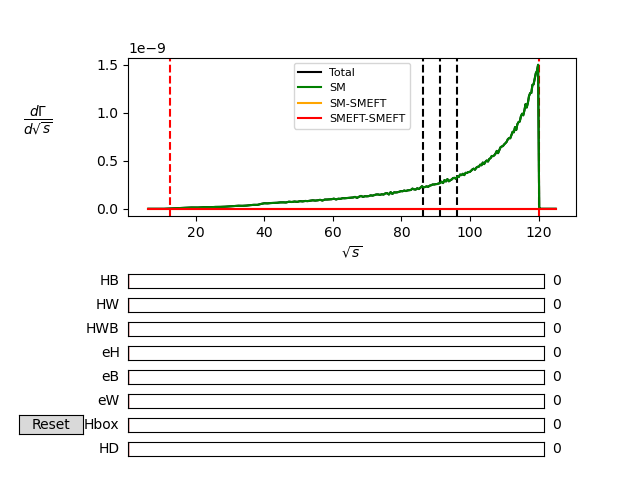

In [42]:
iHB_init = 0 
iHW_init = 0
iHWB_init = 0
ieH_init = 0
ieB_init = 0 
ieW_init = 0
iHD_init = 0
iHbox_init = 0
K = 0.1

sqs = []
ss = []
for i in range(0, bins):
    ss += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (t_max_fix - t_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
sqs = np.array(ss) ** 0.5
    
I_4_1 = np.array(rick.load(open('I_41_Tree', 'rb')))
I_6_1 = np.array(rick.load(open('I_61_Tree', 'rb')))
I_6_2 = np.array(rick.load(open('I_62_Tree', 'rb')))
I_6_3 = np.array(rick.load(open('I_63_Tree', 'rb')))
I_6_4 = np.array(rick.load(open('I_64_Tree', 'rb')))
I_6_5 = np.array(rick.load(open('I_65_Tree', 'rb')))
I_8_6 = np.array(rick.load(open('I_86_Tree', 'rb')))
I_8_7 = np.array(rick.load(open('I_87_Tree', 'rb')))
I_8_8 = np.array(rick.load(open('I_88_Tree', 'rb')))
I_8_9 = np.array(rick.load(open('I_89_Tree', 'rb')))
I_8_10 = np.array(rick.load(open('I_810_Tree', 'rb')))
mas_ls = [I_4_1, I_6_1, I_6_2, I_6_3, I_6_4, I_6_5, I_8_6, I_8_7, I_8_8, I_8_9, I_8_10]

for i in range(0, len(mas_ls)):
    for k in range(0, 2):
        for j in range(0, bins):
            mas_ls[i][k][j] = mas_ls[i][k][j] / sdbins[j]

def t_4sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    t_4sum = 0
    t_4errsum = 0
    for j in range(0, 1):
        t_4sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        t_4errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return np.array([t_4sum,t_4errsum])

def t_6sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    t_6sum = 0
    t_6errsum = 0
    for j in range(1, 6):
        t_6sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        t_6errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return np.array([t_6sum,t_6errsum])

def t_8sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    t_8sum = 0
    t_8errsum = 0
    for j in range(6, 11):
        t_8sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        t_8errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return np.array([t_8sum,t_8errsum])

fig, ax = plt.subplots()
#plt.yscale('log')
#plt.ylim(-10**-9, 10**-8)
plt.axvline(x = K*m_h, color = 'red', linestyle = '--')
plt.axvline(x = (m_h ** 2 - 2 * m_h * E_phot_min)**0.5, color = 'red', linestyle = '--')
plt.axvline(x = m_Z, linestyle = '--', color = 'black')
plt.axvline(x = m_Z-5, linestyle = '--', color = 'black')
plt.axvline(x = m_Z+5, linestyle = '--', color = 'black')

line_sum, = ax.plot(sqs, t_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] +t_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] +t_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'black', label = 'Total')
line_4, = ax.plot(sqs, t_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'green', label = 'SM')
line_6, = ax.plot(sqs, t_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'orange', label = 'SM-SMEFT')
line_8, = ax.plot(sqs, t_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'red', label = 'SMEFT-SMEFT')
ax.set_ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel(r'$\sqrt{s}$')
plt.legend(fontsize = 8)

fig.subplott_adjust(left=0.2, bottom=0.55)

axs = fig.add_axes([0.2, 0.4, 0.65, 0.03])
HB_slider = Slider(
    ax=axs,
    label='HB',
    valmin=0,
    valmax=100,
    valinit=iHB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.35, 0.65, 0.03])
HW_slider = Slider(
    ax=axs,
    label='HW',
    valmin=0,
    valmax=100,
    valinit=iHW_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.3, 0.65, 0.03])
HWB_slider = Slider(
    ax=axs,
    label='HWB',
    valmin=0,
    valmax=100,
    valinit=iHWB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.25, 0.65, 0.03])
eH_slider = Slider(
    ax=axs,
    label='eH',
    valmin=0,
    valmax=100,
    valinit=ieH_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.2, 0.65, 0.03])
eB_slider = Slider(
    ax=axs,
    label='eB',
    valmin=0,
    valmax=1000,
    valinit=ieB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.15, 0.65, 0.03])
eW_slider = Slider(
    ax=axs,
    label='eW',
    valmin=0,
    valmax=100,
    valinit=ieW_init,
    color = 'gray')
                          
axs = fig.add_axes([0.2, 0.1, 0.65, 0.03])
Hbox_slider = Slider(
    ax=axs,
    label='Hbox',
    valmin=0,
    valmax=100,
    valinit=iHbox_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.05, 0.65, 0.03])
HD_slider = Slider(
    ax=axs,
    label='HD',
    valmin=0,
    valmax=100,
    valinit=iHD_init,
    color = 'gray')                          
                          
def update(val):
    line_sum.set_ydata(t_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] +t_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] +t_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_4.set_ydata(t_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_6.set_ydata(t_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_8.set_ydata(t_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    fig.canvas.draw_idle()

HB_slider.on_changed(update)
HW_slider.on_changed(update)
HWB_slider.on_changed(update)
eH_slider.on_changed(update)
eB_slider.on_changed(update)
eW_slider.on_changed(update)
Hbox_slider.on_changed(update)
HD_slider.on_changed(update)                          

resetax = fig.add_axes([0.03, 0.095, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    HB_slider.reset()
    HW_slider.reset()
    HWB_slider.reset()
    eH_slider.reset()
    eB_slider.reset()
    eW_slider.reset()
    Hbox_slider.reset()
    HD_slider.reset()                     
button.on_clicked(reset)

plt.show()

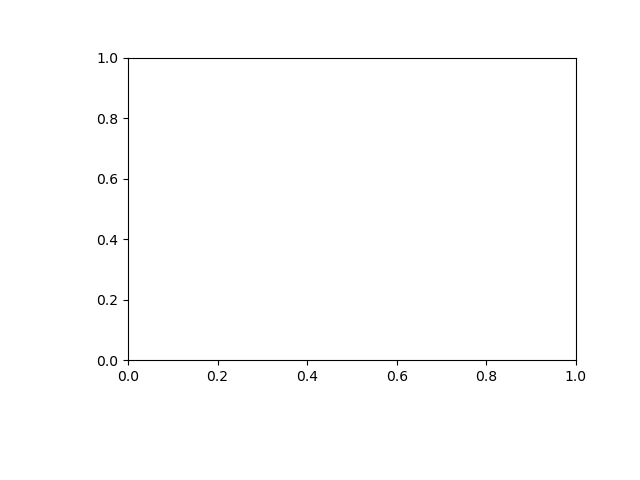

In [66]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.2, bottom=0.25)

num = 10

C_HBs = np.linspace(0, 100, num) * (m_m / (v * 10 ** 6))
C_HWs = np.linspace(0, 10, num) * (m_m / (v * 10 ** 6))
C_HWBs = C_HWs
C_eHs = C_HWs
C_eBs = np.ones(num) * 0.1 * (m_m / (v * 10 ** 6))
C_eWs = C_eBs
C_Hboxs = C_eBs
C_HDs = C_eBs

sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
sqt = np.array(ts) ** 0.5

I_4_1t = np.array(rick.load(open('I_41t_Tree', 'rb')))
I_6_1t = np.array(rick.load(open('I_61t_Tree', 'rb')))
I_6_2t = np.array(rick.load(open('I_62t_Tree', 'rb')))
I_6_3t = np.array(rick.load(open('I_63t_Tree', 'rb')))
I_6_4t = np.array(rick.load(open('I_64t_Tree', 'rb')))
I_6_5t = np.array(rick.load(open('I_65t_Tree', 'rb')))
I_8_6t = np.array(rick.load(open('I_86t_Tree', 'rb')))
I_8_7t = np.array(rick.load(open('I_87t_Tree', 'rb')))
I_8_8t = np.array(rick.load(open('I_88t_Tree', 'rb')))
I_8_9t = np.array(rick.load(open('I_89t_Tree', 'rb')))
I_8_10t = np.array(rick.load(open('I_810t_Tree', 'rb')))
mas_ls = [I_4_1t, I_6_1t, I_6_2t, I_6_3t, I_6_4t, I_6_5t, I_8_6t, I_8_7t, I_8_8t, I_8_9t, I_8_10t]

for i in range(0, len(mas_ls)):
    for k in range(0, 2):
        for j in range(0, bins):
            mas_ls[i][k][j] = mas_ls[i][k][j] / tdbins[j]

def t_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs):
    return scale_anim(l, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)

def t_4sum_init(i):
    cot_4sum = 0
    cot_4errsum = 0
    for j in range(0, 1):
        cot_4sum += t_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cot_4errsum += t_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cot_4sum, cot_4errsum])

def t_6sum_init(i):
    cot_6sum = 0
    cot_6errsum = 0
    for j in range(1, 6):
        cot_6sum += t_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cot_6errsum += t_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cot_6sum, cot_6errsum])

def t_8sum_init(i):
    cot_8sum = 0
    cot_8errsum = 0
    for j in range(6, 11):
        cot_8sum += t_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j]
        cot_8errsum += t_anim(mas_ls, C_HBs, C_HWs, C_HWBs, C_eHs, C_eBs, C_eWs, C_Hboxs, C_HDs)[i, 2*j + 1]
    return np.array([cot_8sum, cot_8errsum])

def animate(i):
    ax.clear()
    plt.ylim(-0.5 * 10**-9, 1 * 10**-9)
    #plt.yscale('log')
    #plt.axvline(x = t_max(t_max_fix, m)**0.5, color = 'red', linestyle = '--')
    #plt.axvline(x = t_min(t_max_fix, m)**0.5, color = 'red', linestyle = '--')
    #plt.axvline(x = m_Z, linestyle = '--', color = 'black')
    #plt.axvline(x = m_Z-2.5*Gam_Z**0.5, linestyle = '--', color = 'black')
    #plt.axvline(x = m_Z+2.5*Gam_Z**0.5, linestyle = '--', color = 'black')
    ax.tick_params(direction='in', length=4, width=1)
    ax.errorbar(sqt, t_4sum_init(i)[0],  color = 'green', label = 'SM', yerr = t_4sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(sqt, t_6sum_init(i)[0],  color = 'orange', label = 'SM-SMEFT', yerr = t_6sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(sqt, t_8sum_init(i)[0],  color = 'red', label = 'SMEFT-SMEFT', yerr = t_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    ax.errorbar(sqt, t_4sum_init(i)[0]+t_6sum_init(i)[0]+t_8sum_init(i)[0],  color = 'black', label = 'Total', yerr = t_4sum_init(i)[1]+t_6sum_init(i)[1]+t_8sum_init(i)[1], ls = 'none', markersize = 4, marker = '.')
    plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
    ax.text(20, 1.05*10**-9, r'$x(C_{HWB})=x(C_{HW})=x(C_{eH})=$' +str(round(C_HWBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(20, 1.15*10**-9, r'$x(C_{HB})=$' +str(round(C_HBs[i] * ((v * 10 ** 6) / m_m)))+'', fontsize = 10)
    ax.text(85, 1.05*10**-9, r'$x(C_{eB})=x(C_{eW})=$' +str(round(C_eBs[i] * ((v * 10 ** 6) / m_m),2))+'', fontsize = 10)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.xlabel(r'$\sqrt{t} GeV$')
    plt.legend(loc='lower right', fontsize = 8)
    
anim = FuncAnimation(fig, animate, interval=200, frames=num, repeat=False)
#anim.save('t.gif', writer='pillow')
plt.show()

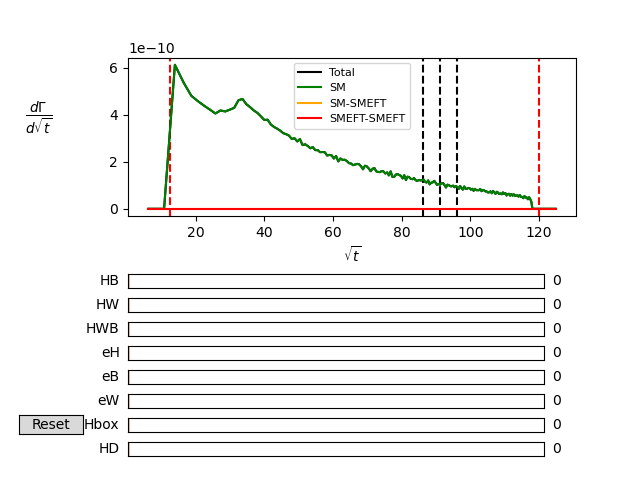

In [44]:
iHB_init = 0 
iHW_init = 0
iHWB_init = 0
ieH_init = 0
ieB_init = 0 
ieW_init = 0
iHD_init = 0
iHbox_init = 0
K = 0.1

sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
sqt = np.array(ts) ** 0.5
    
I_4_1t = np.array(rick.load(open('I_41t_Tree', 'rb')))
I_6_1t = np.array(rick.load(open('I_61t_Tree', 'rb')))
I_6_2t = np.array(rick.load(open('I_62t_Tree', 'rb')))
I_6_3t = np.array(rick.load(open('I_63t_Tree', 'rb')))
I_6_4t = np.array(rick.load(open('I_64t_Tree', 'rb')))
I_6_5t = np.array(rick.load(open('I_65t_Tree', 'rb')))
I_8_6t = np.array(rick.load(open('I_86t_Tree', 'rb')))
I_8_7t = np.array(rick.load(open('I_87t_Tree', 'rb')))
I_8_8t = np.array(rick.load(open('I_88t_Tree', 'rb')))
I_8_9t = np.array(rick.load(open('I_89t_Tree', 'rb')))
I_8_10t = np.array(rick.load(open('I_810t_Tree', 'rb')))
mas_ls = [I_4_1t, I_6_1t, I_6_2t, I_6_3t, I_6_4t, I_6_5t, I_8_6t, I_8_7t, I_8_8t, I_8_9t, I_8_10t]

for i in range(0, len(mas_ls)):
    for k in range(0, 2):
        for j in range(0, bins):
            mas_ls[i][k][j] = mas_ls[i][k][j] / tdbins[j]

def t_4sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    t_4sum = 0
    t_4errsum = 0
    for j in range(0, 1):
        t_4sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        t_4errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return np.array([t_4sum,t_4errsum])

def t_6sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    t_6sum = 0
    t_6errsum = 0
    for j in range(1, 6):
        t_6sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        t_6errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return np.array([t_6sum,t_6errsum])

def t_8sum_init(ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB):
    t_8sum = 0
    t_8errsum = 0
    for j in range(6, 11):
        t_8sum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][0]
        t_8errsum += scale(mas_ls, ieB, ieW, ieH, iHD, iHbox, iHB, iHW, iHWB)[j][1]
    return np.array([t_8sum,t_8errsum])

fig, ax = plt.subplots()
#plt.yscale('log')
#plt.ylim(-10**-9, 10**-8)
plt.axvline(x = K*m_h, color = 'red', linestyle = '--')
plt.axvline(x = (m_h ** 2 - 2 * m_h * E_phot_min)**0.5, color = 'red', linestyle = '--')
plt.axvline(x = m_Z, linestyle = '--', color = 'black')
plt.axvline(x = m_Z-5, linestyle = '--', color = 'black')
plt.axvline(x = m_Z+5, linestyle = '--', color = 'black')

line_sum, = ax.plot(sqt, t_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] +t_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0] +t_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'black', label = 'Total')
line_4, = ax.plot(sqt, t_4sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'green', label = 'SM')
line_6, = ax.plot(sqt, t_6sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'orange', label = 'SM-SMEFT')
line_8, = ax.plot(sqt, t_8sum_init(ieB_init, ieW_init, ieH_init, iHD_init, iHbox_init, iHB_init, iHW_init, iHWB_init)[0], color = 'red', label = 'SMEFT-SMEFT')
ax.set_ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel(r'$\sqrt{t}$')
plt.legend(fontsize = 8)

fig.subplots_adjust(left=0.2, bottom=0.55)

axs = fig.add_axes([0.2, 0.4, 0.65, 0.03])
HB_slider = Slider(
    ax=axs,
    label='HB',
    valmin=0,
    valmax=100,
    valinit=iHB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.35, 0.65, 0.03])
HW_slider = Slider(
    ax=axs,
    label='HW',
    valmin=0,
    valmax=100,
    valinit=iHW_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.3, 0.65, 0.03])
HWB_slider = Slider(
    ax=axs,
    label='HWB',
    valmin=0,
    valmax=100,
    valinit=iHWB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.25, 0.65, 0.03])
eH_slider = Slider(
    ax=axs,
    label='eH',
    valmin=0,
    valmax=100,
    valinit=ieH_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.2, 0.65, 0.03])
eB_slider = Slider(
    ax=axs,
    label='eB',
    valmin=0,
    valmax=1000,
    valinit=ieB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.15, 0.65, 0.03])
eW_slider = Slider(
    ax=axs,
    label='eW',
    valmin=0,
    valmax=100,
    valinit=ieW_init,
    color = 'gray')
                          
axs = fig.add_axes([0.2, 0.1, 0.65, 0.03])
Hbox_slider = Slider(
    ax=axs,
    label='Hbox',
    valmin=0,
    valmax=100,
    valinit=iHbox_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.05, 0.65, 0.03])
HD_slider = Slider(
    ax=axs,
    label='HD',
    valmin=0,
    valmax=100,
    valinit=iHD_init,
    color = 'gray')                          
                          
def update(val):
    line_sum.set_ydata(t_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] +t_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0] +t_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_4.set_ydata(t_4sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_6.set_ydata(t_6sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    line_8.set_ydata(t_8sum_init(eB_slider.val, eW_slider.val, eH_slider.val, HD_slider.val, Hbox_slider.val, HB_slider.val, HW_slider.val, HWB_slider.val)[0])
    fig.canvas.draw_idle()

HB_slider.on_changed(update)
HW_slider.on_changed(update)
HWB_slider.on_changed(update)
eH_slider.on_changed(update)
eB_slider.on_changed(update)
eW_slider.on_changed(update)
Hbox_slider.on_changed(update)
HD_slider.on_changed(update)                          

resetax = fig.add_axes([0.03, 0.095, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    HB_slider.reset()
    HW_slider.reset()
    HWB_slider.reset()
    eH_slider.reset()
    eB_slider.reset()
    eW_slider.reset()
    Hbox_slider.reset()
    HD_slider.reset()                     
button.on_clicked(reset)

plt.show()

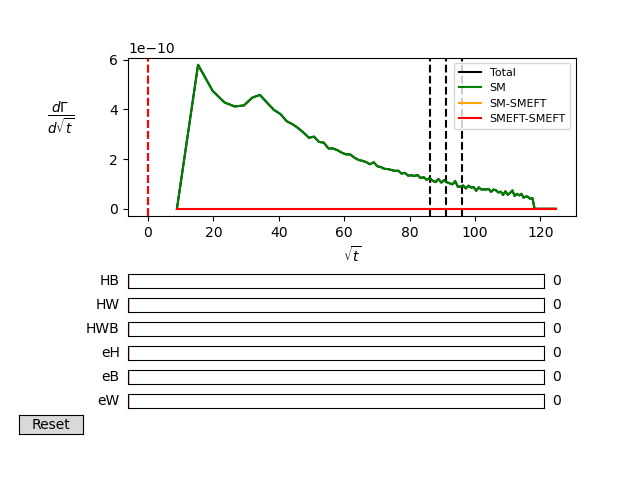

In [11]:
i_HB_init = 0 
i_HW_init = 0
i_HWB_init = 0
i_eH_init = 0
i_eB_init = 0 
i_eW_init = 0
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
sqt = np.array(ts) ** 0.5

I_4_1t = np.array(rick.load(open('I_4_1tmat_sep1', 'rb')))
I_6_1t = np.array(rick.load(open('I_6_1tmat_sep1', 'rb')))
I_6_2t = np.array(rick.load(open('I_6_2tmat_sep1', 'rb')))
I_6_3t = np.array(rick.load(open('I_6_3tmat_sep1', 'rb')))
I_6_4t = np.array(rick.load(open('I_6_4tmat_sep1', 'rb')))
I_8_5t = np.array(rick.load(open('I_8_5tmat_sep1', 'rb')))
I_8_6t = np.array(rick.load(open('I_8_6tmat_sep1', 'rb')))
I_8_7t = np.array(rick.load(open('I_8_7tmat_sep1', 'rb')))
I_8_8t = np.array(rick.load(open('I_8_8tmat_sep1', 'rb')))
I_8_9t = np.array(rick.load(open('I_8_9tmat_sep1', 'rb')))
I_8_10t = np.array(rick.load(open('I_8_10tmat_sep1', 'rb')))
mas_ls = [I_4_1t, I_6_1t, I_6_2t, I_6_3t, I_6_4t, I_8_5t, I_8_6t, I_8_7t, I_8_8t, I_8_9t, I_8_10t]

for i in range(0, len(mas_ls)):
    for k in range(0, 2):
        for j in range(0, bins):
            mas_ls[i][k][j] = mas_ls[i][k][j] / tdbins[j]

def t_4sum_init(i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW):
    cot_4sum = 0
    cot_4errsum = 0
    for j in range(0, 1):
        cot_4sum += scale(mas_ls, i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW)[j][0]
        cot_4errsum += scale(mas_ls, i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW)[j][1]
    return np.array([cot_4sum, cot_4errsum])

def t_6sum_init(i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW):
    cot_6sum = 0
    cot_6errsum = 0
    for j in range(1, 5):
        cot_6sum += scale(mas_ls, i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW)[j][0]
        cot_6errsum += scale(mas_ls, i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW)[j][1]
    return np.array([cot_6sum, cot_6errsum])

def t_8sum_init(i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW):
    cot_8sum = 0
    cot_8errsum = 0
    for j in range(5, 11):
        cot_8sum += scale(mas_ls, i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW)[j][0]
        cot_8errsum += scale(mas_ls, i_HB, i_HW, i_HWB, i_eH, i_eB, i_eW)[j][1]
    return np.array([cot_8sum, cot_8errsum])

fig, ax = plt.subplots()
#plt.ylim(-0.1, 1)
#plt.yscale('log')
plt.axvline(x = t_max(t_max_fix, m)**0.5, color = 'red', linestyle = '--')
plt.axvline(x = t_min(t_max_fix, m)**0.5, color = 'red', linestyle = '--')
plt.axvline(x = m_Z, linestyle = '--', color = 'black')
plt.axvline(x = m_Z-5, linestyle = '--', color = 'black')
plt.axvline(x = m_Z+5, linestyle = '--', color = 'black')
line_sum, = ax.plot(sqt, t_4sum_init(i_HB_init, i_HW_init, i_HWB_init, i_eH_init, i_eB_init, i_eW_init)[0] + t_6sum_init(i_HB_init, i_HW_init, i_HWB_init, i_eH_init, i_eB_init, i_eW_init)[0] + t_8sum_init(i_HB_init, i_HW_init, i_HWB_init, i_eH_init, i_eB_init, i_eW_init)[0], color = 'black', label = 'Total')
line_4, = ax.plot(sqt, t_4sum_init(i_HB_init, i_HW_init, i_HWB_init, i_eH_init, i_eB_init, i_eW_init)[0], color = 'green', label = 'SM')
line_6, = ax.plot(sqt, t_6sum_init(i_HB_init, i_HW_init, i_HWB_init, i_eH_init, i_eB_init, i_eW_init)[0], color = 'orange', label = 'SM-SMEFT')
line_8, = ax.plot(sqt, t_8sum_init(i_HB_init, i_HW_init, i_HWB_init, i_eH_init, i_eB_init, i_eW_init)[0], color = 'red', label = 'SMEFT-SMEFT')
ax.set_ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.set_xlabel(r'$\sqrt{t}$')
plt.legend(fontsize = 8)

fig.subplott_adjust(left=0.2, bottom=0.55)

axs = fig.add_axes([0.2, 0.4, 0.65, 0.03])
HB_slider = Slider(
    ax=axs,
    label='HB',
    valmin=0,
    valmax=100,
    valinit=i_HB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.35, 0.65, 0.03])
HW_slider = Slider(
    ax=axs,
    label='HW',
    valmin=0,
    valmax=100,
    valinit=i_HW_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.3, 0.65, 0.03])
HWB_slider = Slider(
    ax=axs,
    label='HWB',
    valmin=0,
    valmax=100,
    valinit=i_HWB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.25, 0.65, 0.03])
eH_slider = Slider(
    ax=axs,
    label='eH',
    valmin=0,
    valmax=100,
    valinit=i_eH_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.2, 0.65, 0.03])
eB_slider = Slider(
    ax=axs,
    label='eB',
    valmin=0,
    valmax=100,
    valinit=i_eB_init,
    color = 'gray')

axs = fig.add_axes([0.2, 0.15, 0.65, 0.03])
eW_slider = Slider(
    ax=axs,
    label='eW',
    valmin=0,
    valmax=100,
    valinit=i_eW_init,
    color = 'gray')

def update(val):
    line_sum.set_ydata(t_4sum_init(HB_slider.val, HW_slider.val, HWB_slider.val, eH_slider.val, eB_slider.val, eW_slider.val)[0] + t_6sum_init(HB_slider.val, HW_slider.val, HWB_slider.val, eH_slider.val, eB_slider.val, eW_slider.val)[0] + t_8sum_init(HB_slider.val, HW_slider.val, HWB_slider.val, eH_slider.val, eB_slider.val, eW_slider.val)[0])
    line_4.set_ydata(t_4sum_init(HB_slider.val, HW_slider.val, HWB_slider.val, eH_slider.val, eB_slider.val, eW_slider.val)[0])
    line_6.set_ydata(t_6sum_init(HB_slider.val, HW_slider.val, HWB_slider.val, eH_slider.val, eB_slider.val, eW_slider.val)[0])
    line_8.set_ydata(t_8sum_init(HB_slider.val, HW_slider.val, HWB_slider.val, eH_slider.val, eB_slider.val, eW_slider.val)[0])
    fig.canvas.draw_idle()

HB_slider.on_changed(update)
HW_slider.on_changed(update)
HWB_slider.on_changed(update)
eH_slider.on_changed(update)
eB_slider.on_changed(update)
eW_slider.on_changed(update)

resetax = fig.add_axes([0.03, 0.095, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    HB_slider.reset()
    HW_slider.reset()
    HWB_slider.reset()
    eH_slider.reset()
    eB_slider.reset()
    eW_slider.reset()
button.on_clicked(reset)

plt.show()